In [118]:
import pandas as pd 
import numpy as np
from scipy import linalg, stats
from scipy.linalg import svd, svdvals
from sklearn.cross_decomposition import PLSRegression

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower


#### Read the dataset

In [119]:
df = pd.read_parquet('../data/covid19/datasetForPLS-DA.parquet')
dfContr = df[df['batch_id'].isin(['DMSO', 'non-inf'])].copy() # select wells with DMSO in infected and noninfected cells
dfContr.reset_index(inplace=True, drop=True)

#### Define the functions to perform whitening and compute Mahalanobis distance

**Whitening** is a transformation that takes the distribution of Healthy cells and maps them to such space that
1. has orthogonal directions – each feature is uncorrelated with others,
2. these directions span the most of the covariance – they capture the scattering of Healthy cells best,
3. new space has lower dimension - we can drop those orthogonal directions that span too little information (same as in PCA),
4. orthogonal directions are standartized – the scattering of Healthy cells becomes uniform along each direction; hence each feauture impacts our distance equally.

**Mahalanobis distance** = Ordinary Euclidean distance computed after whitening transformation

In [120]:
def compute_whitening_transform(cells, rank=None):
    cov_matrix = np.cov(cells, rowvar=False)
    sigma, u = linalg.eigh(cov_matrix, check_finite=True)
    descending_idx = sigma.argsort()[::-1]
    sigma = sigma[descending_idx]
    u = u[:, descending_idx]
    
    if rank is None:
        eps = np.finfo(u.dtype.char.lower()).eps
        rtol = np.max(np.abs(sigma)) * max(cov_matrix.shape) * eps
        cutoff = (abs(sigma) > rtol)
        rank = np.sum(cutoff)
    else:
        cutoff = (sigma > 0.)
        rank = min(np.sum(cutoff), rank)
    
    psigma_diag = 1.0 / sigma[:rank]
    whitening_transform = np.diag(np.sqrt(psigma_diag)) @ u.T[:rank, :]
    return whitening_transform, rank


def compute_whitening_transform_robust(cells, rank=None):
    u, sigma, vt = linalg.svd(cells - np.mean(cells, axis=0), check_finite=True)
    descending_idx = sigma.argsort()[::-1]
    sigma = sigma[descending_idx]
    u = u[:, descending_idx]
    vt = vt[descending_idx, :]

    if rank is None:
        eps = np.finfo(u.dtype.char.lower()).eps
        rtol = np.max(np.abs(sigma)) * max(cov_matrix.shape) * eps
        cutoff = (abs(sigma) > rtol)
        rank = np.sum(cutoff)
    else:
        cutoff = (sigma > 0.)
        rank = min(np.sum(cutoff), rank)
    cells = u[:, :rank] @ np.diag(sigma[:rank]) @ vt[:rank, :]

    cov_matrix = MinCovDet().fit(cells).covariance_
    whitening_transform = linalg.inv(whitening_transform)
    return whitening_transform, rank


def get_distance(healthy_cells, cells, n_components=None, robust=False):
    if robust:
        whitening_transform, n_components = compute_whitening_transform_robust(healthy_cells, rank=n_components)
    else:
        whitening_transform, n_components = compute_whitening_transform(healthy_cells, rank=n_components)

    whitening_transform, n_components = compute_whitening_transform(healthy_cells, rank=n_components)
    healthy_mean = np.mean(healthy_cells, axis=0)
    delta = (cells - healthy_mean).T
    delta = whitening_transform @ delta
    distance = np.linalg.norm(delta, ord=2, axis=0)
    return distance


def get_distance_deviation(healthy_cells, cells, n_components=None, robust=False):
    if robust:
        whitening_transform, n_components = compute_whitening_transform_robust(healthy_cells, rank=n_components)
    else:
        whitening_transform, n_components = compute_whitening_transform(healthy_cells, rank=n_components)

    whitening_transform, n_components = compute_whitening_transform(healthy_cells, rank=n_components)
    healthy_mean = np.mean(healthy_cells, axis=0)
    delta = (cells - healthy_mean).T
    delta = whitening_transform @ delta
    distance = np.linalg.norm(delta, ord=2, axis=0)
    chi_squared_mode = n_components - 2
    deviation = distance - np.sqrt(chi_squared_mode)
    return deviation


def get_proba(healthy_cells, cells, n_components=None, robust=False):
    if robust:
        whitening_transform, n_components = compute_whitening_transform_robust(healthy_cells, rank=n_components)
    else:
        whitening_transform, n_components = compute_whitening_transform(healthy_cells, rank=n_components)

    whitening_transform, n_components = compute_whitening_transform(healthy_cells, rank=n_components)
    healthy_mean = np.mean(healthy_cells, axis=0)
    delta = (cells - healthy_mean).T
    delta = whitening_transform @ delta
    distance = np.linalg.norm(delta, ord=2, axis=0)
    proba = 1 - stats.chi2.cdf(distance**2, df=n_components)
    return proba



#### Selecting effective dimension

(by looking at the singular values from PCA)

In [121]:
# There are some methods in literature that allow to automatically select the optimal number of components from PCA
# We employ one such method below

def svht(X, sigma=None):
    """
    Return the optimal singular value hard threshold (SVHT) value from [1].
    `X` is any m-by-n matrix. `sigma` is the standard deviation of the 
    noise, if known. Implementation from [2].
    [1] Gavish, Matan, and David L. Donoho. “The optimal hard threshold for singular values is.” IEEE Transactions on Information Theory 60.8 (2014): 5040-5053.
    [2] Robert Taylor. "Optimal Singular Value Hard Threshold." https://humaticlabs.com/blog/optimal-svht/.
    """

    def omega_approx(beta):
        '''Return an approximate omega value for given beta. Equation (5) from Gavish 2014.'''
        return 0.56 * beta**3 - 0.95 * beta**2 + 1.82 * beta + 1.43

    def lambda_star(beta):
        '''Return lambda star for given beta. Equation (11) from Gavish 2014.'''
        return np.sqrt(2 * (beta + 1) + (8 * beta) / 
                    (beta + 1 + np.sqrt(beta**2 + 14 * beta + 1)))
    
    try:
        m,n = sorted(X.shape) # ensures m <= n
    except:
        raise ValueError('invalid input matrix')
    beta = m / n # ratio between 0 and 1
    if sigma is None: # sigma unknown
        sv = svdvals(X)
        sv = np.squeeze(sv)
        if sv.ndim != 1:
            raise ValueError('vector of singular values must be 1-dimensional')
        return np.median(sv) * omega_approx(beta)
    else: # sigma known
        return lambda_star(beta) * np.sqrt(n) * sigma

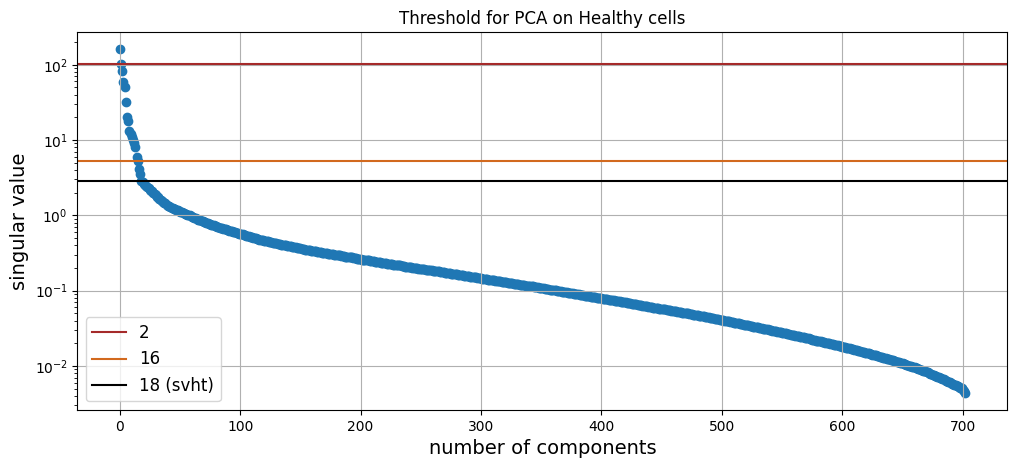

In [122]:
df_healthy = df[df['batch_id'] == 'non-inf']
x_healthy = df_healthy.iloc[:, 7:].to_numpy()

cov_matrix = np.cov(x_healthy, rowvar=False)
sigma, u = linalg.eigh(cov_matrix, check_finite=True)
rank = min(*x_healthy.shape) - 1
sigma = sigma[::-1]
plt.scatter(range(rank), sigma[:rank])

n_components = 2
plt.axhline(sigma[n_components - 1], c='brown', label=n_components)

n_components = np.count_nonzero(sigma > 5)
plt.axhline(sigma[n_components - 1], c='chocolate', label=n_components)

# optimal threshold for PCA of Healthy cells
tau = svht(x_healthy)
plt.axhline(sigma[int(tau)], c='k', label=f'{int(tau)} (svht)')

plt.grid()
plt.yscale('log')
plt.legend(fontsize=12)
plt.xlabel('number of components', fontsize=14)
plt.ylabel('singular value', fontsize=14)
plt.title("Threshold for PCA on Healthy cells")
plt.show()

#### Computing predictions: PLS-DA, correlations, and Mahalanobis distance

In [123]:
x_all = df.iloc[:, 7:].copy()
clip = 50 # if we want to clip eventual extreme values; otherwise float('inf')
x_all.clip(lower=-clip, upper=clip, inplace=True)

PLS-DA allows to identify the drugs with too low effect – by comparing positive and negative control (non-infectected vs DMSO)

In [124]:
# PLS predictions
x = dfContr.iloc[:,7:]
x.clip(lower=-clip, upper=clip, inplace=True)
y = np.where(dfContr['pert_type'] == 'negcon', 0, 1)
pls = PLSRegression(n_components=2, scale=False)
pls.fit(x, y)
pls_pred = pls.predict(x_all)
pls_pred = pd.DataFrame(pls_pred, columns=['pls'])

Illustration for PLS-DA: non-infected, DMSO, and Remdesevir at different concentrations

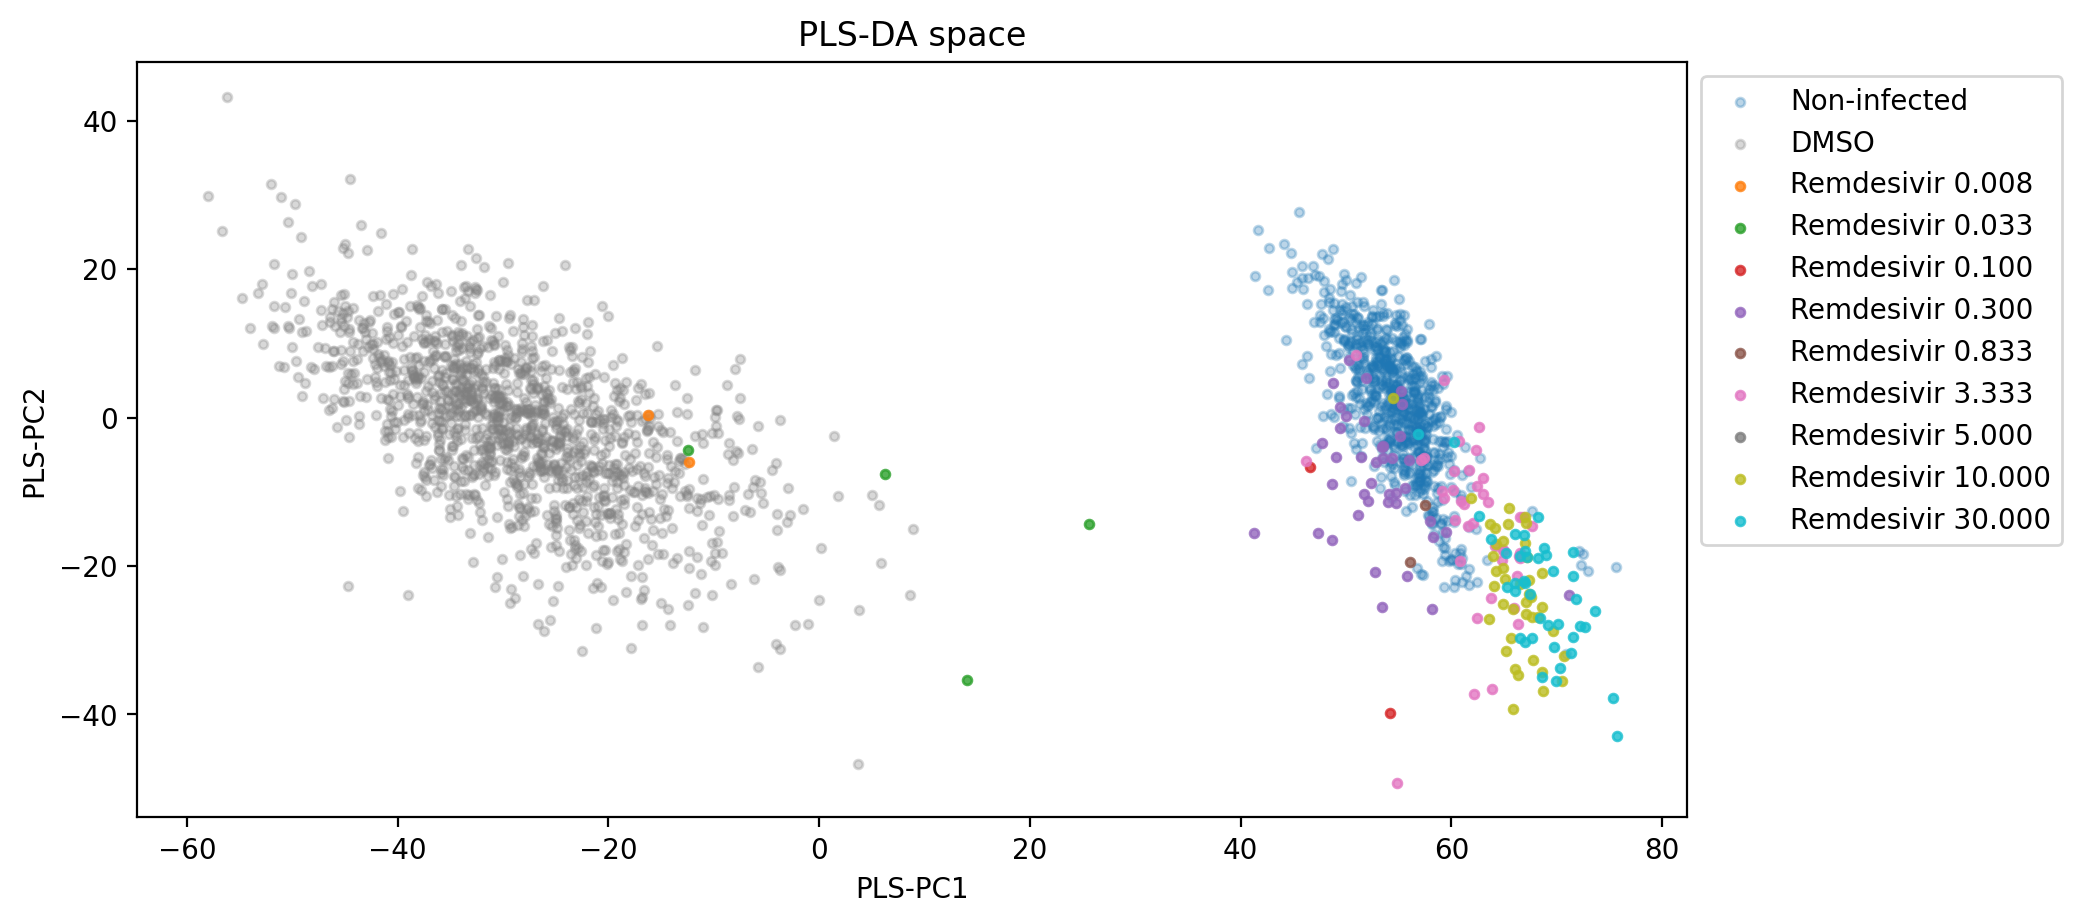

In [125]:
x_pls = pls.transform(x_all)
plt.figure(figsize=(10,5), dpi= 200)

batch_names = {
    'DMSO': 'DMSO', 
    'non-inf': 'Uninfected', 
    'DD4386006': 'Remdesivir'
}
conc_list = sorted(set([float(conc.split('_')[-1]) for conc in df['comp_conc']]))

# Non-infected
non_inf = df['batch_id'] == 'non-inf'
non_inf_points = x_pls[non_inf].T
plt.scatter(non_inf_points[0], non_inf_points[1], label='Non-infected', s=10, alpha=0.3)

# DMSO (no treatment effect)
dmso = df['batch_id'] == 'DMSO'
dmso_points = x_pls[dmso].T
plt.scatter(dmso_points[0], dmso_points[1], label='DMSO', s=10, alpha=0.3, color='gray')

# Remdesivir
for conc in conc_list:
    points = x_pls[df['comp_conc'] == f"DD4386006_{conc}"].T
    plt.scatter(points[0], points[1], label=f"Remdesivir {float(conc):.3f}", s=10, alpha=0.8)
    
plt.xlabel("PLS-PC1")
plt.ylabel("PLS-PC2")
plt.title("PLS-DA space")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

#### Whitening and Mahalanobis distance

In [126]:
# Predictions based on whitening transform
n_components = 18

# Distance to Healthy (Mahalanobis)
df_healthy = df[df['batch_id'] == 'non-inf']
x_healthy = df_healthy.iloc[:, 7:].to_numpy()
dist_pred = get_distance(x_healthy, x_all, n_components=n_components)
dist_pred = pd.DataFrame(dist_pred, columns=['distance'])

# Probability of Healthy
proba_pred = get_proba(x_healthy, x_all, n_components=n_components)
proba_pred = pd.DataFrame(proba_pred, columns=['proba'])

#### Concatenate predictions


In [127]:
predictions = pd.concat([df.iloc[:, :7], pls_pred, dist_pred, proba_pred], axis=1)
predictions.to_csv('output/Predictions.csv', sep=';')

Use the separate file that maps `batch_id` to the name of each drug

In [128]:
with open("id_to_name.txt", 'r') as file:
    table = file.readlines()

id_to_name = {}
for i, line in enumerate(table):
    id_, name = line.rstrip().split('\t')
    id_to_name[id_] = name

In [129]:
# Read the type of dtug for one concentration measurements: primary_hit, secondary_cp_hit, analog
one_conc_type = pd.read_csv("../data/covid19/metadata_annotations.csv", usecols=["CBCSbatch_id", "arm"])
one_conc_type.rename(columns={"CBCSbatch_id": "batch_id", "arm": "type"}, inplace=True)

#### Ranking all compounds by distance

Rows in the ranking below correspond to different compounds at different concentrations, i.e., we average over replicates.

In [130]:
def quantile(n):
    def quantile_(x):
        return x.quantile(n)
    quantile_.__name__ = f'q_{n*100:.0f}'
    return quantile_

selected_columns = predictions[[
    'batch_id', 'cmpd_conc', 'Count_nuclei', 
    'pls', 
    'distance',
    # 'proba',
]]
# Aggregate replicates
average_predictions = selected_columns.groupby(by=['batch_id', 'cmpd_conc'], as_index=False).agg({
        'Count_nuclei': 'median', 
        'pls': [quantile(.25), quantile(.75), 'median'],
        'distance': [quantile(.25), quantile(.75), 'median'],
        # 'proba': 'median',
})
# Rename columns
custom_columns = [''.join(col) for col in average_predictions.columns.to_flat_index() if not col[1]]
custom_columns += ['_'.join(col) for col in average_predictions.columns.to_flat_index() if col[1]]
average_predictions.columns = custom_columns

# Sort by distance to non-infected
average_predictions.sort_values(by=['distance_median'], ascending=True, inplace=True)

average_predictions['name'] = average_predictions['batch_id'].map(id_to_name)
# Quantiles are written as plus/minus to the median
average_predictions['distance_q_75'] = average_predictions['distance_q_75'] - average_predictions['distance_median']
average_predictions['distance_q_25'] =  average_predictions['distance_median'] - average_predictions['distance_q_25']

average_predictions.reset_index(inplace=True, drop=True)
average_predictions.to_csv("output/Predictions.csv", sep=';')
average_predictions.head(20)

,batch_id,cmpd_conc,Count_nuclei_median,pls_q_25,pls_q_75,pls_median,distance_q_25,distance_q_75,distance_median,name
0,non-inf,0.300000,307.00,0.954188,1.006469,0.983199,0.496122,0.741883,3.858445,non-inf
1,DO8167002,0.833333,300.50,0.926838,0.985911,0.956375,0.098640,0.098640,3.935111,Nirmatrelvir
2,DO8167002,10.000000,289.50,0.938701,0.983830,0.965922,0.383166,0.780670,4.118547,Nirmatrelvir
3,DO8167002,3.333333,295.25,0.903253,0.992483,0.959236,0.526657,1.100842,4.162268,Nirmatrelvir
4,DI1202001,3.333333,291.50,0.912297,0.958339,0.932826,0.642382,0.970900,4.276881,GC376
5,DO8167002,30.000000,289.00,0.936139,0.991036,0.962468,0.752730,0.544792,4.568228,Nirmatrelvir
6,DI1202001,10.000000,299.50,0.944578,1.003045,0.970137,0.253117,0.503210,4.687156,GC376
7,DD4386006,0.300000,290.75,0.869676,0.930846,0.908579,0.367370,0.898335,4.729768,remdesivir
8,BJ1895621,10.000000,277.00,0.811092,0.871468,0.820551,0.020938,1.958436,5.192341,Propiverine Hydrochloride
9,BJ1898414,3.333333,264.00,0.657587,0.747457,0.679770,0.297448,1.501355,5.339885,LY2608204


**Note**: after the whitening, the squared distance is distributed as a chi-squared random variable – $\chi^2_d$, where $d$ is the selected effective dimension. We can use to test compunds against confidence intervals of this distribution.

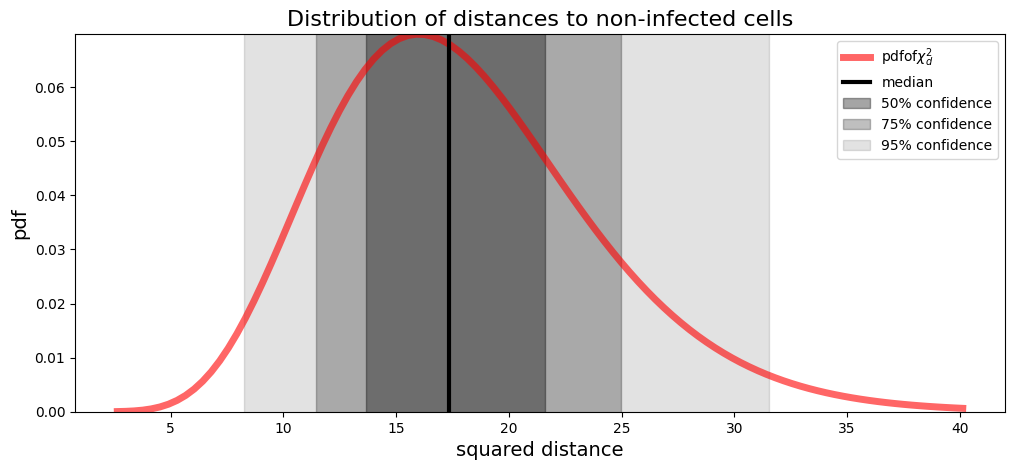

In [131]:
x = np.linspace(stats.chi2.ppf(1e-5, df=n_components), stats.chi2.ppf(1-2e-3, df=n_components), 100)
pdf = stats.chi2.pdf(x, df=n_components)
plt.plot(x, pdf, 'r-', lw=5, alpha=0.6, label=r'$\mathrm{pdf of } \chi^2_d$')
plt.axvline(stats.chi2.median(df=n_components), label='median', c='k', lw=3)
for conf in (0.5, 0.75, 0.95):
    left, right = stats.chi2.interval(conf, df=n_components)
    plt.fill_betweenx(y=np.linspace(-1, 0.1, 2), x1=left, x2=right, label=f'{conf*100:.0f}% confidence',
                      color='k', alpha=0.5*(1-conf)**0.5)
plt.legend()
plt.ylim(0, max(pdf))
plt.xlabel("squared distance", fontsize=14)
plt.ylabel("pdf", fontsize=14)
plt.title("Distribution of distances to non-infected cells",  fontsize=16)
plt.show()

Hence, we can rank drugs based on the following: does the distance from a treated cell to an average healthy cell fall into the confidence interval? Furthermore, we can look at this criterion at different concentrations.

Below is the distance vs concentration plot. Three control drugs are depicted with errorbars – median distance and 25%-75% quantiles. At the bottom we have the median distance for Healthy cells and its confidence intervals (50%, 75%, and 95%).

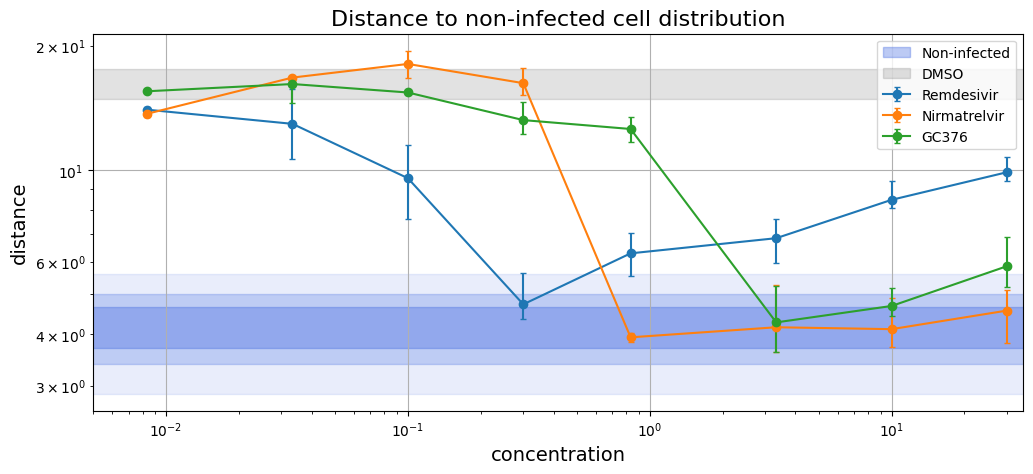

In [132]:
compounds = average_predictions.copy()

# Control drugs
drug_names = {
    'DD4386006': 'Remdesivir',
    'DO8167002': 'Nirmatrelvir', 
    'DI1202001': 'GC376',
}

# Drugs - statistics from experimental results
for drug_id, drug_name in drug_names.items():
    drug = compounds[compounds['batch_id'] == drug_id].sort_values(by=['cmpd_conc'], ascending=True)
    conc = drug['cmpd_conc'].to_numpy()
    median = drug['distance_median'].to_numpy()
    perc_25 = drug['distance_q_25'].to_numpy()
    perc_75 = drug['distance_q_75'].to_numpy()
    if drug_name.lower() != 'dmso':
        plt.errorbar(conc, median, yerr=[perc_25, perc_75], 
                     capsize=2, elinewidth=1.5, fmt='o-', label=drug_name)


# Non-infected cells - confidence intervals
non_inf = compounds[compounds['batch_id'] == 'non-inf']
conc = range(0, 40, 1)
for i, conf in enumerate([0.5, 0.75, 0.95]):
    label = "Non-infected" if i == 0 else None
    left, right = stats.chi2.interval(confidence=conf, df=n_components)
    plt.fill_between(conc, np.sqrt(left), np.sqrt(right), 
                     color='royalblue', alpha=0.5*(1-conf)**0.5, 
                     zorder=1, label=label
    )
# median = n_components * (1 - 2 / (9 * n_components))**3
# plt.plot(conc, [np.sqrt(median)] * len(conc), color='k', label='Healthy')


# DMSO
drug = compounds[compounds['batch_id'] == 'DMSO']
conc = range(0, 40, 1)
median = drug['distance_median'].to_numpy()
perc_25 = drug['distance_q_25'].to_numpy()
perc_75 = drug['distance_q_75'].to_numpy()
plt.fill_between(
    conc, median-perc_25, median+perc_75, 
    color='k', alpha=0.5*(1-conf)**0.5, 
    zorder=1, label='DMSO'
)

plt.legend()
plt.grid()
plt.xscale('log')
plt.xlabel("concentration", fontsize=14)
plt.xlim(0.5e-2, 35)

plt.yscale('log') 
plt.ylabel("distance", fontsize=14)

plt.title("Distance to non-infected cell distribution", fontsize=16)
plt.show()

Threshold for the distance


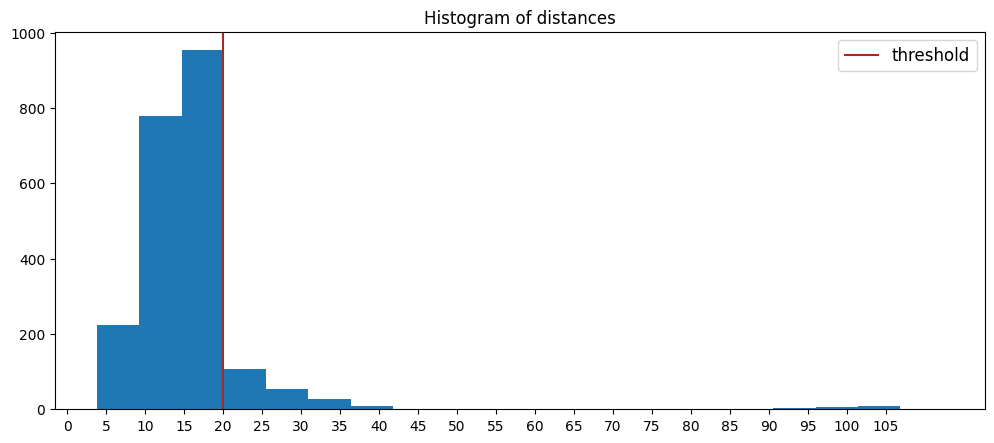

In [133]:
plt.hist(average_predictions['distance_median'], bins=20)
plt.title("Histogram of distances")
plt.axvline(20, c='brown', label='threshold')
plt.xticks(np.arange(0, 110, 5))
plt.legend(fontsize=12)
plt.show()

THRESH = 20

### Let us now look at the interactive plots

In [134]:
## Run this cell to install the library for interactive graphs

# !pip3 install plotly
# !pip3 install --upgrade nbformat

Hint: double-click on any trace to only show this particular trace and hide all others. Subsequently, you can click on the labels in the legend to switch on the traces that you want to add to the plot.


In [135]:
import plotly.express as px
import plotly.graph_objects as go


def plot_compounds_interactive(compounds, dmso=None):
    drug_names = {
        id_: name_ for (id_, name_) in zip(compounds['batch_id'], compounds['name'])
    }

    drugs = compounds[~compounds['batch_id'].isin(['non-inf', 'DMSO'])]
    fig = px.line(
        drugs.sort_values(by="cmpd_conc"), x="cmpd_conc", y="distance_median",
        color='name', markers=True,
        width=1200, height=400,
        error_y='distance_q_75', error_y_minus='distance_q_75',
        category_orders={"name": drug_names.values()},
    )

    # Healthy cells - confidence intervals
    for i, conf in enumerate([0.5, 0.75, 0.95]):
        label = dict(
            text="Non-infected", font=dict(size=15, color="black"), textposition="middle left"
        ) if i == 0 else None

        left, right = stats.chi2.interval(confidence=conf, df=n_components)
        fig.add_hrect(
            type="rect",
            y0=np.sqrt(left), y1=np.sqrt(right),
            fillcolor="royalblue", opacity=0.8*(1-conf)**0.5,
            layer="below", line_width=0, label=label
        )

    # DMSO
    if dmso is not None:
        conc = range(0, 31, 1)
        median = dmso['distance_median'].iloc[0]
        perc_25 = dmso['distance_q_25'].iloc[0]
        perc_75 = dmso['distance_q_75'].iloc[0]
        fig.add_hrect(
            type="rect",
            y0=median-perc_25, y1=median+perc_75,
            fillcolor="grey", opacity=0.25,
            layer="below", line_width=0,
            label=dict(
                text="DMSO", font=dict(size=15, color="black"), textposition="middle left"
            )
        )

    conc = np.unique(compounds['cmpd_conc'])
    fig.update_xaxes(title_text="concentration", gridcolor='lightgrey', type="log", tickvals=conc)
    fig.update_yaxes(title_text="distance", gridcolor='lightgrey', type="log", tickvals=[1, 5, 10, 100])
    fig.update_layout(
        title_text="Distance to non-infected cell distribution",
        plot_bgcolor='white'
    )
    fig.rcParams['figure.figsize'] = [40, 10]

    fig.show()


In [136]:
# compounds = average_predictions.copy()
compounds = average_predictions[average_predictions['distance_median'] <= THRESH].copy()
dmso = compounds[compounds['batch_id'] == 'DMSO']

plot_compounds_interactive(compounds, dmso)

ValueError: Invalid property specified for object of type plotly.graph_objs.layout.Shape: 'label'

Did you mean "layer"?

    Valid properties:
        editable
            Determines whether the shape could be activated for
            edit or not. Has no effect when the older editable
            shapes mode is enabled via `config.editable` or
            `config.edits.shapePosition`.
        fillcolor
            Sets the color filling the shape's interior. Only
            applies to closed shapes.
        fillrule
            Determines which regions of complex paths constitute
            the interior. For more info please visit
            https://developer.mozilla.org/en-
            US/docs/Web/SVG/Attribute/fill-rule
        layer
            Specifies whether shapes are drawn below or above
            traces.
        line
            :class:`plotly.graph_objects.layout.shape.Line`
            instance or dict with compatible properties
        name
            When used in a template, named items are created in the
            output figure in addition to any items the figure
            already has in this array. You can modify these items
            in the output figure by making your own item with
            `templateitemname` matching this `name` alongside your
            modifications (including `visible: false` or `enabled:
            false` to hide it). Has no effect outside of a
            template.
        opacity
            Sets the opacity of the shape.
        path
            For `type` "path" - a valid SVG path with the pixel
            values replaced by data values in
            `xsizemode`/`ysizemode` being "scaled" and taken
            unmodified as pixels relative to `xanchor` and
            `yanchor` in case of "pixel" size mode. There are a few
            restrictions / quirks only absolute instructions, not
            relative. So the allowed segments are: M, L, H, V, Q,
            C, T, S, and Z arcs (A) are not allowed because radius
            rx and ry are relative. In the future we could consider
            supporting relative commands, but we would have to
            decide on how to handle date and log axes. Note that
            even as is, Q and C Bezier paths that are smooth on
            linear axes may not be smooth on log, and vice versa.
            no chained "polybezier" commands - specify the segment
            type for each one. On category axes, values are numbers
            scaled to the serial numbers of categories because
            using the categories themselves there would be no way
            to describe fractional positions On data axes: because
            space and T are both normal components of path strings,
            we can't use either to separate date from time parts.
            Therefore we'll use underscore for this purpose:
            2015-02-21_13:45:56.789
        templateitemname
            Used to refer to a named item in this array in the
            template. Named items from the template will be created
            even without a matching item in the input figure, but
            you can modify one by making an item with
            `templateitemname` matching its `name`, alongside your
            modifications (including `visible: false` or `enabled:
            false` to hide it). If there is no template or no
            matching item, this item will be hidden unless you
            explicitly show it with `visible: true`.
        type
            Specifies the shape type to be drawn. If "line", a line
            is drawn from (`x0`,`y0`) to (`x1`,`y1`) with respect
            to the axes' sizing mode. If "circle", a circle is
            drawn from ((`x0`+`x1`)/2, (`y0`+`y1`)/2)) with radius
            (|(`x0`+`x1`)/2 - `x0`|, |(`y0`+`y1`)/2 -`y0`)|) with
            respect to the axes' sizing mode. If "rect", a
            rectangle is drawn linking (`x0`,`y0`), (`x1`,`y0`),
            (`x1`,`y1`), (`x0`,`y1`), (`x0`,`y0`) with respect to
            the axes' sizing mode. If "path", draw a custom SVG
            path using `path`. with respect to the axes' sizing
            mode.
        visible
            Determines whether or not this shape is visible.
        x0
            Sets the shape's starting x position. See `type` and
            `xsizemode` for more info.
        x1
            Sets the shape's end x position. See `type` and
            `xsizemode` for more info.
        xanchor
            Only relevant in conjunction with `xsizemode` set to
            "pixel". Specifies the anchor point on the x axis to
            which `x0`, `x1` and x coordinates within `path` are
            relative to. E.g. useful to attach a pixel sized shape
            to a certain data value. No effect when `xsizemode` not
            set to "pixel".
        xref
            Sets the shape's x coordinate axis. If set to a x axis
            id (e.g. "x" or "x2"), the `x` position refers to a x
            coordinate. If set to "paper", the `x` position refers
            to the distance from the left of the plotting area in
            normalized coordinates where 0 (1) corresponds to the
            left (right). If set to a x axis ID followed by
            "domain" (separated by a space), the position behaves
            like for "paper", but refers to the distance in
            fractions of the domain length from the left of the
            domain of that axis: e.g., *x2 domain* refers to the
            domain of the second x  axis and a x position of 0.5
            refers to the point between the left and the right of
            the domain of the second x axis.
        xsizemode
            Sets the shapes's sizing mode along the x axis. If set
            to "scaled", `x0`, `x1` and x coordinates within `path`
            refer to data values on the x axis or a fraction of the
            plot area's width (`xref` set to "paper"). If set to
            "pixel", `xanchor` specifies the x position in terms of
            data or plot fraction but `x0`, `x1` and x coordinates
            within `path` are pixels relative to `xanchor`. This
            way, the shape can have a fixed width while maintaining
            a position relative to data or plot fraction.
        y0
            Sets the shape's starting y position. See `type` and
            `ysizemode` for more info.
        y1
            Sets the shape's end y position. See `type` and
            `ysizemode` for more info.
        yanchor
            Only relevant in conjunction with `ysizemode` set to
            "pixel". Specifies the anchor point on the y axis to
            which `y0`, `y1` and y coordinates within `path` are
            relative to. E.g. useful to attach a pixel sized shape
            to a certain data value. No effect when `ysizemode` not
            set to "pixel".
        yref
            Sets the shape's y coordinate axis. If set to a y axis
            id (e.g. "y" or "y2"), the `y` position refers to a y
            coordinate. If set to "paper", the `y` position refers
            to the distance from the bottom of the plotting area in
            normalized coordinates where 0 (1) corresponds to the
            bottom (top). If set to a y axis ID followed by
            "domain" (separated by a space), the position behaves
            like for "paper", but refers to the distance in
            fractions of the domain length from the bottom of the
            domain of that axis: e.g., *y2 domain* refers to the
            domain of the second y  axis and a y position of 0.5
            refers to the point between the bottom and the top of
            the domain of the second y axis.
        ysizemode
            Sets the shapes's sizing mode along the y axis. If set
            to "scaled", `y0`, `y1` and y coordinates within `path`
            refer to data values on the y axis or a fraction of the
            plot area's height (`yref` set to "paper"). If set to
            "pixel", `yanchor` specifies the y position in terms of
            data or plot fraction but `y0`, `y1` and y coordinates
            within `path` are pixels relative to `yanchor`. This
            way, the shape can have a fixed height while
            maintaining a position relative to data or plot
            fraction.
        
Did you mean "layer"?

Bad property path:
label
^^^^^

### Lastly, we look at the compounds at only one dosage (plot against Remdesivir for comparison)

In [ ]:
compounds = average_predictions.copy()
# compounds = average_predictions[average_predictions['distance_median'] <= THRESH].copy()
dmso = compounds[compounds['batch_id'] == 'DMSO']

# Extract one-dosage measurements
one_conc_drugs = compounds[~compounds['batch_id'].duplicated()].copy()
batch_id = one_conc_drugs['batch_id']

# Control
antiviral_control_id = one_conc_type[one_conc_type['type'] == 'antiviral_control']['batch_id'].to_list()
antiviral_control = one_conc_drugs[one_conc_drugs['batch_id'].isin(antiviral_control_id)].copy()

cp_control_id = one_conc_type[one_conc_type['type'] == 'cp_control']['batch_id'].to_list()
cp_control = one_conc_drugs[one_conc_drugs['batch_id'].isin(cp_control_id)].copy()

##### Primary hit

In [ ]:
# Extract primary hit
primary_hit_id = one_conc_type[one_conc_type['type'] == 'primary_hit']['batch_id'].to_list()
primary_hits = one_conc_drugs[one_conc_drugs['batch_id'].isin(primary_hit_id)].copy()

# Concatenate with control
selected_compounds = pd.concat([primary_hits, antiviral_control, cp_control])

plot_compounds_interactive(selected_compounds, dmso)


##### Secondary hit

In [ ]:
# Extract secondary hit
secondary_hit_id = one_conc_type[one_conc_type['type'] == 'secondary_cp_hit']['batch_id'].to_list()
secondary_hits = one_conc_drugs[one_conc_drugs['batch_id'].isin(secondary_hit_id)].copy()

# Concatenate with control
selected_compounds = pd.concat([secondary_hits, antiviral_control, cp_control])

plot_compounds_interactive(selected_compounds, dmso)


##### Analog

In [ ]:
# Extract analogs
analog_id = one_conc_type[one_conc_type['type'] == 'analog']['batch_id'].to_list()
analogs = one_conc_drugs[one_conc_drugs['batch_id'].isin(analog_id)].copy()

# Concatenate with control
selected_compounds = pd.concat([analogs, antiviral_control, cp_control])

plot_compounds_interactive(selected_compounds, dmso)